# Exploring Brain-Wide Inputs to the Secondary Motor Cortex with the Allen Connectivity Atlas

This project shows how the Allen Mouse Brain Connectivity Atlas can be used to investigate where inputs to a specific brain area come from. Using projection density data from multiple tracer experiments, the code groups injections by source region (e.g., auditory or visual cortices) and looks at how strongly they project to the secondary motor cortex (MOs). By comparing and correlating these inputs, we can get insights into how different sensory systems converge on motor areas — and the same approach could be applied to study afferents to any other brain nucleus or region of interest.

# 1. Set up
Packages to install and import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
%matplotlib inline

Import now data from the allen sdk repository

In [120]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# MouseConnectivityCache has a method for retrieving the adult mouse structure 
# tree as an StructureTree class instance. This is a wrapper around a list of 
# dictionaries, where each dictionary describes a structure. 
# It is principally useful for looking up structures by their properties

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json') #relative path

In [ ]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree() # To see only structure sets relevant to the adult mouse brain, use the StructureTree

# get info on some structures
structures = structure_tree.get_structures_by_acronym(['MOs'])# You can also .get_structures_by_name(['Secondary motor area'])

In [122]:
# On the connectivity atlas web site, they show most of data at a fairly coarse structure level. 
# They did this by creating a structure set of ~300 structures, which we call the "summary structures". 
# We can use the structure tree to get all of the structures in this set
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# 2. Function set up
A bunch of functions to run the code

In [123]:
#Function that computes percentiles of average template intensities in selected
#structures.
def get_median_template_intensity(mouse_connectivity_cache, structure_ids):
    
    mask = mouse_connectivity_cache.get_reference_space().make_structure_mask(structure_ids)
    template, _ = mouse_connectivity_cache.get_template_volume()
                        
    return np.percentile(template[mask > 0].flat, 50, interpolation='lower')

In [124]:
# function that determines the density of signal within a structure (i.e. the fraction of pixels
# in all the voxels in that structure that were detected as signal).
def fraction_of_structure(mouse_connectivity_cache, structure_id, experiment_id):
    
    mask, _ = mouse_connectivity_cache.get_structure_mask(structure_id)
    
    if mask.sum() == 0:
        return 0.0
    
    projection_density, _ = mouse_connectivity_cache.get_projection_density(experiment_id)
    projection_density[mask == 0] = 0
    
    fraction = projection_density.sum() / mask.sum()
    return fraction

In [125]:
def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

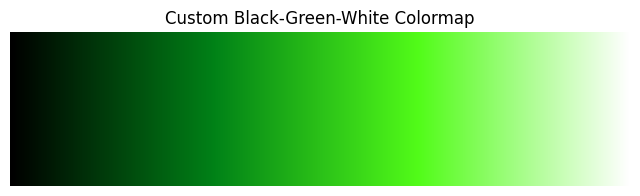

In [126]:
# Define custom colormap: black -> green -> white
green_palette = [(0.00, "#000000"),
                (0.33, "#018217"),
                (0.66, "#52FC19"),
                (1.00, "#FFFFFF")
               ]

blue_palette = [(0.00, "#000000"),
                (0.33, "#0055FF"),
                (0.66, "#1AB5FD"),
                (1.00, "#FFFFFF")
               ]

magenta_palette = [(0.00, "#000000"),
                   (0.33, "#820177"),
                   (0.66, "#FC19A5"),
                   (1.00, "#FFFFFF")
                  ]


#colors_ratio = [
#    (0.0, "black"),    # Values ≤ 0 → Black
#    (0.25, "black"),   # Near 0 but still black
#    (0.35, "green"),   # 0 → Green transition starts
#    (0.75, "white"),   # 1 → White
#    (1.0, "magenta")   # >1 → Magenta
#]

colors_ratio =[(0.00, "#24CB35"),
               (0.50, "#16E7E7"),
               (1.00, "#F500F5")    # 100% → Magenta (hsla(305, 99%, 50%, 1))
]

# Create colormap
custom_green_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_cmap", green_palette)
custom_blue_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue_cmap", blue_palette)
custom_magenta_cmap = mcolors.LinearSegmentedColormap.from_list("custom_magenta_cmap", magenta_palette)
custom_cmap_ratio = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors_ratio)

# Show colormap example
gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Create a gradient for visualization
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=custom_green_cmap)
plt.axis('off')
plt.title("Custom Black-Green-White Colormap")
plt.show()

In [127]:
def axis_proj_green(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the green colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [ ]:
def axis_proj_blue(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the blue colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_blue_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [ ]:
def axis_proj_magenta(data, template, axis, bg_q=90, bg_alpha=0.5):
    """
    To plot the density projections with the magenta colorbar
    """
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    plt.imshow(data_max, interpolation='none', cmap=custom_magenta_cmap)
    plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    plt.axis('off')  # Hide x and y axes

In [ ]:
def axis_proj_green_outline(data, template, axis, bg_q=90, bg_alpha=0.5, structure_masks=None, default_color="white"):
    """
    Plot density projections in green with an outline for specified structure masks.
    """
    # Projection of data & template
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)

    ax = plt.gca()  # use current axes

    # Plot projections
    ax.imshow(data_max, interpolation='none', cmap=custom_green_cmap)
    ax.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=bg_alpha)
    ax.axis('off')

    # Overlay outlines for each structure
    if structure_masks is not None:
        mask_proj = np.amax(structure_masks, axis=axis)
        if np.any(mask_proj):
            ax.contour(mask_proj, levels=[0.5], colors=default_color, linewidths=0.8)

In [130]:
def sign_preserving_projection(data, axis):
    """
    For each (x,y) in the projected plane, select the element along the given axis
    with the largest absolute value, and return that value.
    """
    abs_data = np.abs(data)
    idx = np.argmax(abs_data, axis=axis)
    
    # Use np.take_along_axis to retrieve the values along the specified axis
    proj = np.take_along_axis(data, np.expand_dims(idx, axis=axis), axis=axis)
    # Remove the extra axis
    proj = np.squeeze(proj, axis=axis)
    return proj

In [131]:
def slice_hsv_overlay(selectivity_index, sum_matrix, template, slice_index, axis=1, ax=None, bg_q=90, bg_alpha=1, structure_masks=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Select the appropriate 2D slice
    if axis == 0:
        si_slice = selectivity_index[slice_index, :, :]
        sm_slice = sum_matrix[slice_index, :, :]
        bg_slice = template[slice_index, :, :]
    elif axis == 1:
        si_slice = selectivity_index[:, slice_index, :]
        sm_slice = sum_matrix[:, slice_index, :]
        bg_slice = template[:, slice_index, :]
    elif axis == 2:
        si_slice = selectivity_index[:, :, slice_index]
        sm_slice = sum_matrix[:, :, slice_index]
        bg_slice = template[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2")

    # Normalize and convert HSV to RGB
    sm_norm = np.full_like(sm_slice, np.nan, dtype=np.float32)
    non_zero_mask = sm_slice > 0
    if np.any(non_zero_mask):
        sm_norm[non_zero_mask] = sm_slice[non_zero_mask] / np.nanmax(sm_slice[non_zero_mask])
    else:
        sm_norm[:] = 0

    #hue = np.where(si_slice >= 0, 1/3, 5/6)  # Green or Magenta
    # Map from [-1, 1] → [1/3, 0.75] (green to cyan to magenta)
    si_clipped = np.clip(si_slice, -1, 1)
    hue = (1 - (si_clipped + 1) / 2) * (5/6 - 1/3) + 1/3
    #hue = np.full_like(si_slice, 0.5)  # default to light blue (approx. 0.5 in HSV)
    #hue[si_slice <= -0.25] = 5/6       # green (~0.33)
    #hue[si_slice >= 0.25] = 1/3        # magenta (~0.83)
    #saturation = np.abs(si_slice)      # to have saturation variable in the map
    saturation = np.ones_like(si_slice)
    #value = sm_norm
    value = np.ones_like(saturation)

    alpha_channel = sm_norm
    alpha_channel[~non_zero_mask] = 0
    
    hsv_image = np.stack((hue, saturation, value), axis=-1)
    rgb_image = hsv_to_rgb(hsv_image)
    # Combine RGB and alpha to create an RGBA image
    rgba_image = np.dstack((rgb_image, alpha_channel))

    #alpha = np.abs(si_slice)
    #alpha[~non_zero_mask] = 0

    # Plot anatomical background
    ax.imshow(bg_slice, cmap='gray', alpha=bg_alpha, interpolation='none')

    # Plot HSV overlay
    ax.imshow(rgba_image, interpolation='none')

    # Overlay the structure mask (e.g., MOs)
    if structure_masks is not None:
        for region_name, (mask, color) in structure_masks.items():
            # Extract slice for the current axis
            if axis == 0:
                mask_slice = mask[slice_index, :, :]
            elif axis == 1:
                mask_slice = mask[:, slice_index, :]
            elif axis == 2:
                mask_slice = mask[:, :, slice_index]
            else:
                raise ValueError("Invalid axis. Use 0, 1, or 2.")
            # Plot contour if the mask slice has nonzero data
            if np.any(mask_slice):
                ax.contour(mask_slice, levels=[0.5], colors=color, linewidths=0.5)
    
    ax.axis('off')

# 3. Structure signal unionization
The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. It contains the density of projecting signal, volume of projecting signal, and other information. MouseConnectivityCache provides methods for querying and storing this data.

For this following section, to know which is the acronym of the area(s) you are interested in, first visit the allen brain atlas website
https://atlas.brain-map.org/atlas?atlas=602630314#atlas=602630314&plate=576989940&structure=549&x=5279.999781366604&y=3744.0785151809005&zoom=-3&resolution=NaN&z=3

In [181]:
# find wild-type injections into auditory areas and visual areas
aud = structure_tree.get_structures_by_acronym(['AUD'])[0]
print(aud)

aud_experiments = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[aud['id']])

print("%d AUD experiments" % len(aud_experiments))

vis = structure_tree.get_structures_by_acronym(['VIS'])[0]
print(vis)

vis_experiments = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[vis['id']])

print("%d VIS experiments" % len(vis_experiments))

{'acronym': 'AUD', 'graph_id': 1, 'graph_order': 121, 'id': 247, 'name': 'Auditory areas', 'structure_id_path': [997, 8, 567, 688, 695, 315, 247], 'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 114512891], 'rgb_triplet': [1, 147, 153]}
9 AUD experiments
{'acronym': 'VIS', 'graph_id': 1, 'graph_order': 157, 'id': 669, 'name': 'Visual areas', 'structure_id_path': [997, 8, 567, 688, 695, 315, 669], 'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 112905813, 114512891, 114512892], 'rgb_triplet': [8, 133, 140]}
47 VIS experiments


Get data for single experiments - to retreive them, you can use this piece of code, else go to the allen connectivity website if you want to be more specific and see which other options are available for selecting experiments
https://connectivity.brain-map.org/

In [133]:
# Step 1: Get the structure ID for the auditory areas and visual areas
experiment_ids_aud = []
experiment_ids_vis = []

aud = structure_tree.get_structures_by_acronym(['AUD'])[0]
aud_id = aud['id']

for exp in aud_experiments:
    experiment_ids_aud.append(exp['id'])


vis = structure_tree.get_structures_by_acronym(['VIS'])[0]
vis_id = vis['id']

for exp in vis_experiments:
    experiment_ids_vis.append(exp['id'])

# 4. Manipulating grid data
The MouseConnectivityCache class also helps you download and open every experiment's projection grid data volume. By default it will download 25um volumes, but you could also download data at other resolutions if you prefer (10um, 50um, 100um).

This demonstrates how you can load the projection density for a particular experiment. It also shows how to download the template volume to which all grid data is registered. Voxels in that template have been structurally annotated by neuroanatomists and the resulting labels stored in a separate annotation volume image.

In [134]:
# injection into AUD as example
experiment_id = 146858006

In [135]:
# projection density: number of projecting pixels / voxel volume
proj_d, proj_d_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# data mask:
# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the MOs
cortex_mask, cm_info = mcc.get_structure_mask(993)

print(proj_d_info)
print(proj_d.shape, template.shape, annot.shape)

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])
(528, 320, 456) (528, 320, 456) (528, 320, 456)


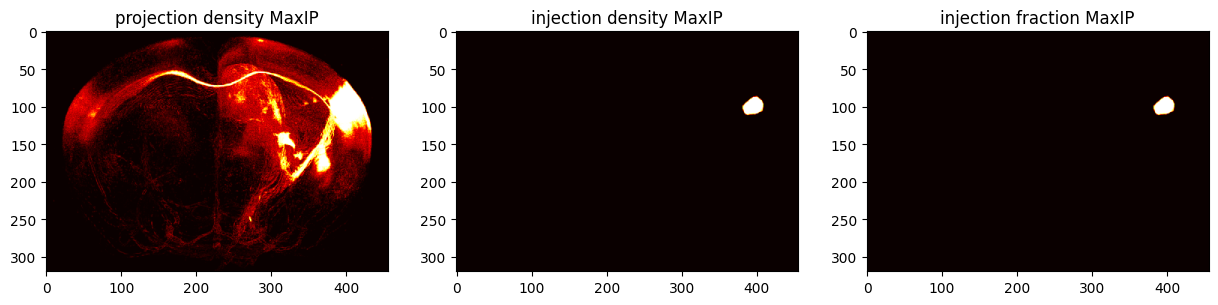

In [136]:
# compute the maximum intensity projection (along the anterior-posterior axis) of the projection data
proj_d_mip = proj_d.max(axis=0)
ind_mip = ind.max(axis=0)
inf_mip = inf.max(axis=0)

# show that slice of all volumes side-by-side
f, pr_axes = plt.subplots(1, 3, figsize=(15, 6))

pr_axes[0].imshow(proj_d_mip, cmap='hot', aspect='equal')
pr_axes[0].set_title("projection density MaxIP")

pr_axes[1].imshow(ind_mip, cmap='hot', aspect='equal')
pr_axes[1].set_title("injection density MaxIP")

pr_axes[2].imshow(inf_mip, cmap='hot', aspect='equal')
pr_axes[2].set_title("injection fraction MaxIP")

plt.show()

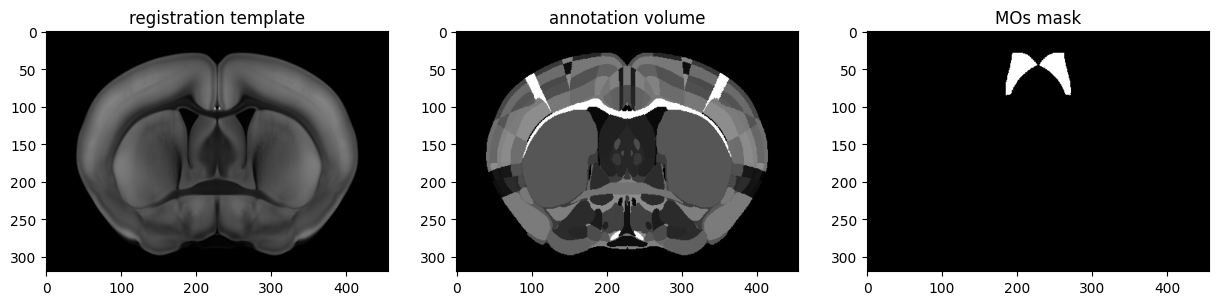

In [137]:
# Look at a slice from the average template and annotation volumes

# pick a slice to show
slice_idx = 210

f, ccf_axes = plt.subplots(1, 3, figsize=(15, 6))

ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("registration template")

ccf_axes[1].imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ccf_axes[1].set_title("annotation volume")

ccf_axes[2].imshow(cortex_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)
ccf_axes[2].set_title("MOs mask")

plt.show()

# 5. Working in 3D
Allen Institute has generated an average template volume from 1675 mouse brain image stacks and registering each connectivity datasets to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF).
You can view the average template volume using your MouseConnectivityCache.

The template is oriented:

anterior -> posterior

superior -> inferior

left -> right

This means that to obtain a sagittal view, we must slice along axis 2, and along axis 1 for a horizontal section (0=coronal, 1=horizontal, 2=sagittal):

(528, 320, 456)


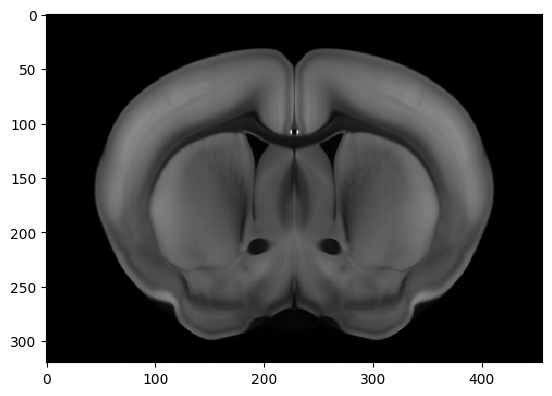

In [138]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print(template.shape)

# 6. The annotation volume

Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.

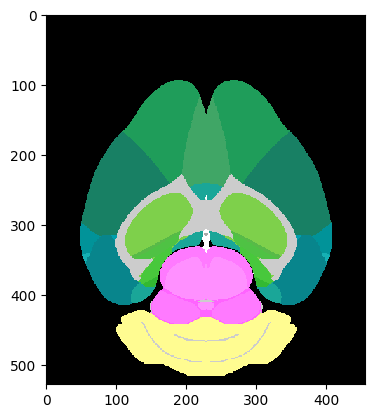

In [139]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
slice_image = reference_space.get_slice_image(1, 1875) # this method wants an axis and a position in microns
plt.imshow(slice_image, interpolation='none')

In [140]:
# you can load up the raw annotation using your MouseConnectivityCache
annotation, _ = mcc.get_annotation_volume()

#I want to find MOs (id=993)

np.where(annotation == 993) #only this would not show up anything, annotation only labels finest structure division at each voxel
MOs_children = structure_tree.children([993])[0]
pd.DataFrame(MOs_children)

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,MOs1,1,25,656,"Secondary motor area, layer 1","[997, 8, 567, 688, 695, 315, 500, 993, 656]","[667481440, 184527634, 12, 691663206]","[31, 157, 90]"
1,MOs2/3,1,26,962,"Secondary motor area, layer 2/3","[997, 8, 567, 688, 695, 315, 500, 993, 962]","[667481441, 184527634, 12, 691663206]","[31, 157, 90]"
2,MOs5,1,27,767,"Secondary motor area, layer 5","[997, 8, 567, 688, 695, 315, 500, 993, 767]","[184527634, 12, 667481446, 691663206]","[31, 157, 90]"
3,MOs6a,1,28,1021,"Secondary motor area, layer 6a","[997, 8, 567, 688, 695, 315, 500, 993, 1021]","[667481449, 184527634, 12, 691663206]","[31, 157, 90]"
4,MOs6b,1,29,1085,"Secondary motor area, layer 6b","[997, 8, 567, 688, 695, 315, 500, 993, 1085]","[184527634, 12, 667481450, 691663206]","[31, 157, 90]"


# 8. Structure Mask
The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:

volumes in the common coordinate framework

1 where the annotation is labeled with a structure or its descendants, otherwise 0

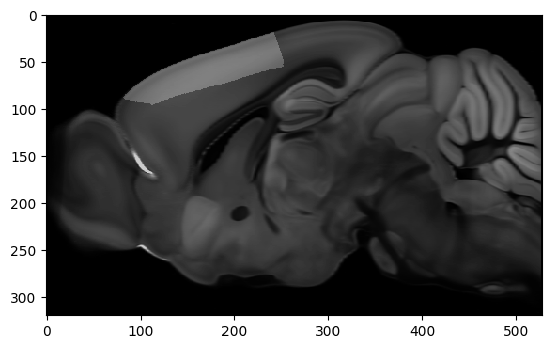

In [141]:
# view a structure mask for MOs
MOs_mask, _ = mcc.get_structure_mask(993)
plt.imshow(MOs_mask[:, :, 200].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 200].T, interpolation='none', cmap=plt.cm.gray, alpha=0.8)

# 9. Gridded projection data
Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.

Here we will load an experiment's projection density volume. These data:

- are floats in [0, 1]

- represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)

- are independent of the injection site (so it makes sense to discuss "projection in the injection site")

In [142]:
prdens, _ = mcc.get_projection_density(115958825) #example experiment

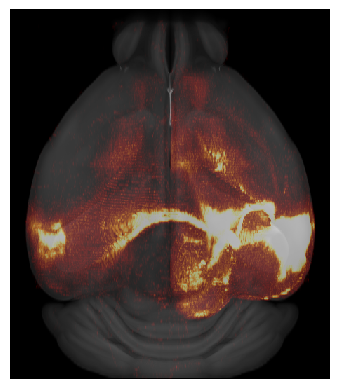

In [143]:
# make a max projection along the anterior-posterior axis for visualization
axis_proj(prdens, template, 1)

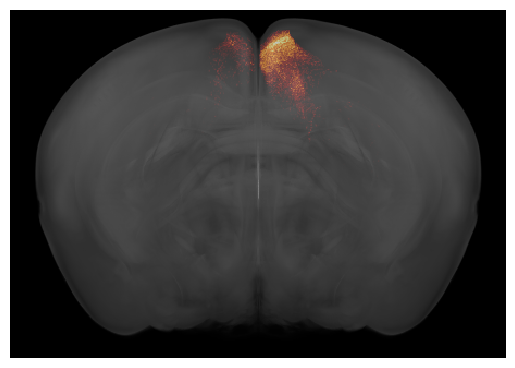

In [144]:
# now filter the signal to MOs
MOs_mask, _ = mcc.get_structure_mask(993)

prdens_MOs = prdens.copy()
prdens_MOs[MOs_mask == 0] = 0
axis_proj(prdens_MOs, template, 0) #coronal

In [145]:
# Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within
# this experiment's manually annotated injection site
ijfr, _ = mcc.get_injection_fraction(307137980)

In [146]:
# Compute Average Projection Density from multiple experiments

# Initialize an array to accumulate projection densities
average_prdens_aud = None
average_prdens_vis = None

# Iterate through experiment IDs
for exp_id in experiment_ids_aud:
    prdens_aud, _ = mcc.get_projection_density(exp_id)  # Load projection density for the experiment
    if average_prdens_aud is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_prdens_aud = np.zeros_like(prdens_aud, dtype=np.float32)
    average_prdens_aud += prdens_aud

for exp_id in experiment_ids_vis:
    prdens_vis, _ = mcc.get_projection_density(exp_id)  # Load projection density for the experiment
    if average_prdens_vis is None:
        # Initialize the accumulator with the shape of the first experiment's data
        average_prdens_vis = np.zeros_like(prdens_vis, dtype=np.float32)
    average_prdens_vis += prdens_vis
    
# Compute the average
average_prdens_aud /= len(experiment_ids_aud)
average_prdens_vis /= len(experiment_ids_vis)

I am using different colors to distinguish the different areas projectiong to the MOs.
- Magenta for Visual Areas
- Green for Auditory Areas
- Blue for the combination of the two 

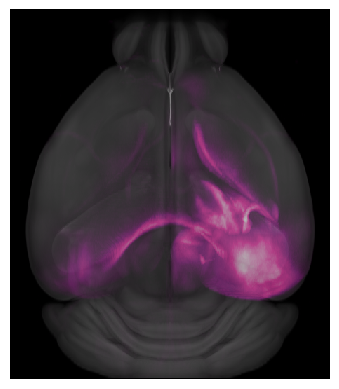

In [147]:
axis_proj_magenta(average_prdens_vis, template, 1)

In [148]:
#Get masks from multiple frontal areas
MO_mask, _ = mcc.get_structure_mask(500)
ACA_mask, _ = mcc.get_structure_mask(31)
PL_mask, _ = mcc.get_structure_mask(972)
ILA_mask, _ = mcc.get_structure_mask(44)
ORB_mask, _ = mcc.get_structure_mask(714)
AI_mask, _ = mcc.get_structure_mask(95)

Combined_frontal_mask = MO_mask | ACA_mask | PL_mask | ILA_mask | ORB_mask | AI_mask

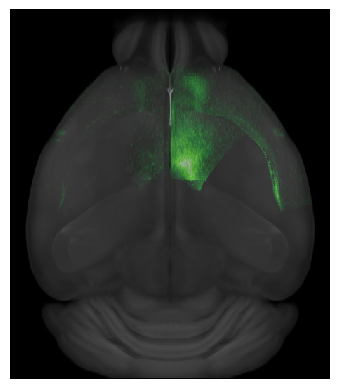

In [149]:
prdens_frontal = average_prdens_aud.copy()
prdens_frontal[Combined_frontal_mask == 0] = 0
axis_proj_green(prdens_frontal, template, 1) 

Projection density value Range in AUD matrix: 0.0 0.7673046
Projection density value Range in VIS matrix: 0.0 0.54269475
Active pixels in vis: 3125933
Active pixels in aud: 2867736


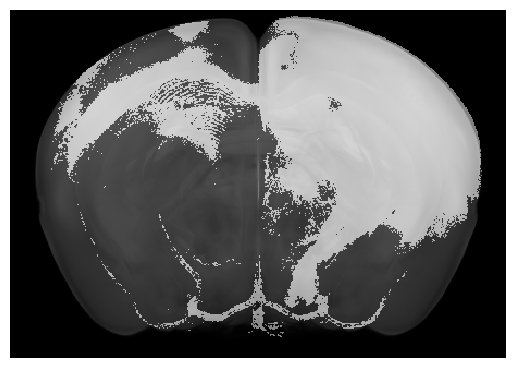

In [150]:
# Define threshold for active pixels
print("Projection density value Range in AUD matrix:", np.nanmin(average_prdens_aud), np.nanmax(average_prdens_aud))
print("Projection density value Range in VIS matrix:", np.nanmin(average_prdens_vis), np.nanmax(average_prdens_vis))
threshold = 0.015 # 0.03 was the value I first used, but you can change it according to how conservative you want to be

# Find active pixels in both datasets
active_aud = average_prdens_aud > threshold
active_vis = average_prdens_vis > threshold
print("Active pixels in vis:", np.count_nonzero(active_vis)) #check number of True pixels in vis matrix
print("Active pixels in aud:", np.count_nonzero(active_aud)) #check number of True pixels in aud matrix


# Find overlap of active pixels
overlap_active = active_aud & active_vis

# Visualize the averaged projection density
axis_proj(overlap_active, template, 0)  # Example: max projection

plt.show()

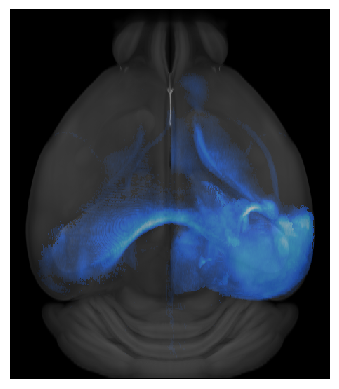

In [151]:
# Initialize combined projection density map
combined_prdens_sum = np.zeros_like(average_prdens_aud)

# Assign combined densities where overlap is active
combined_prdens_sum[overlap_active] = (
    average_prdens_aud[overlap_active] + average_prdens_vis[overlap_active]
)

axis_proj_blue(combined_prdens_sum, template, 1)

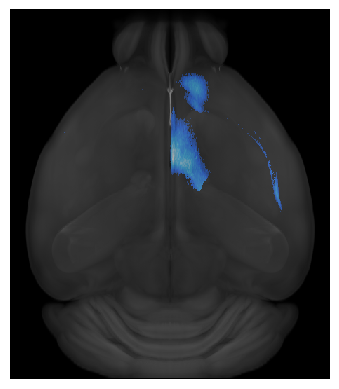

In [152]:
prdens_frontal = combined_prdens_sum.copy()
prdens_frontal[Combined_frontal_mask == 0] = 0
axis_proj_blue(prdens_frontal, template, 1)

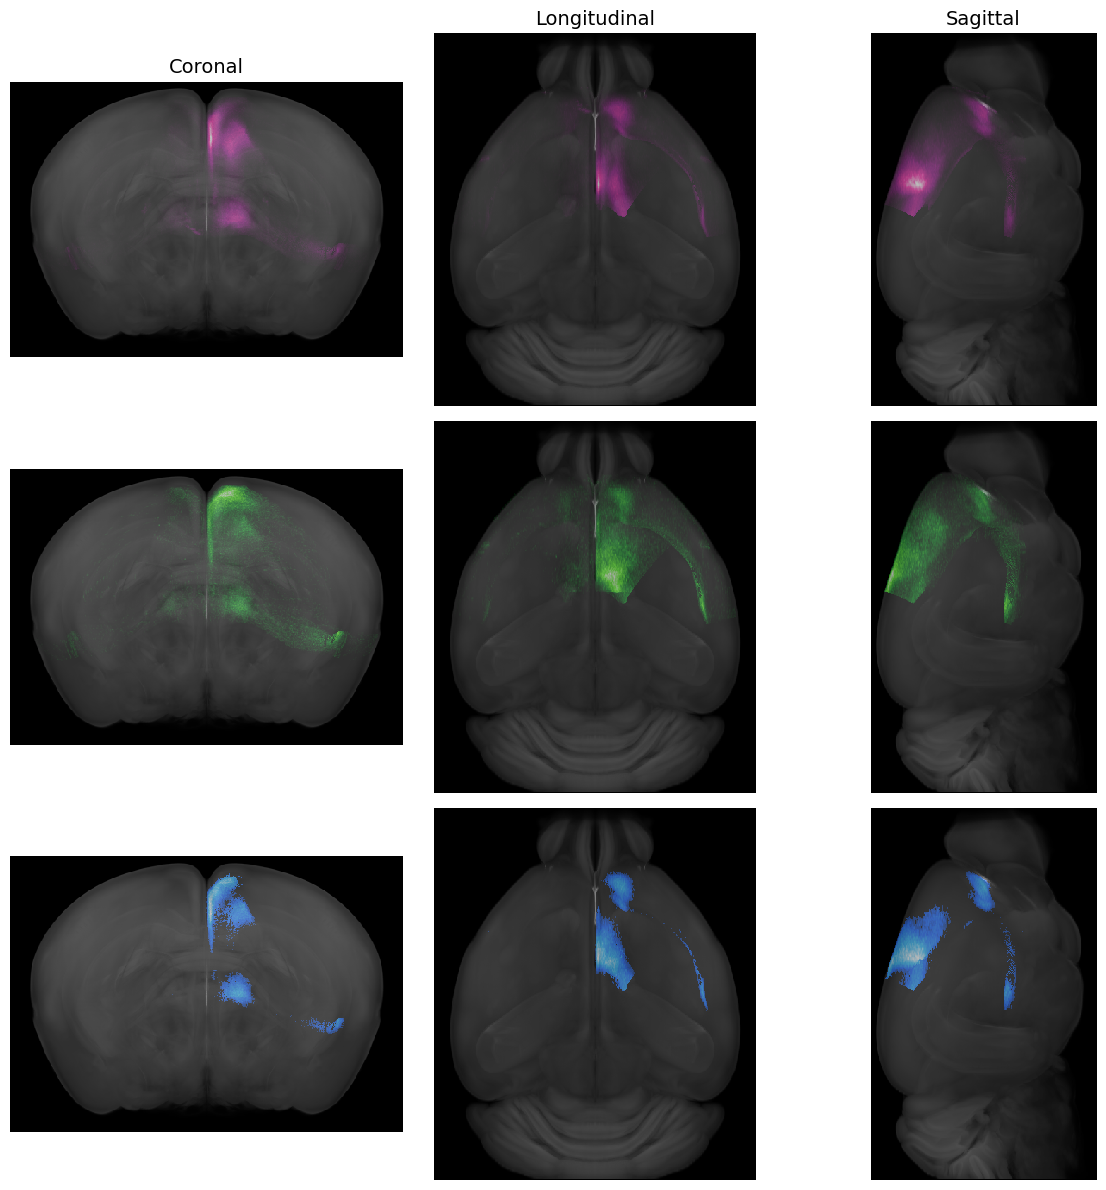

In [153]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# --- Row 1: VISUAL (magenta) ---
prdens_frontal = average_prdens_vis.copy()
prdens_frontal[Combined_frontal_mask == 0] = 0
plt.sca(axes[0, 0]); axis_proj_magenta(prdens_frontal, template, 0)
plt.sca(axes[0, 1]); axis_proj_magenta(prdens_frontal, template, 1)
plt.sca(axes[0, 2]); axis_proj_magenta(prdens_frontal, template, 2)

# --- Row 2: AUDITORY (green) ---
prdens_frontal = average_prdens_aud.copy()
prdens_frontal[Combined_frontal_mask == 0] = 0
plt.sca(axes[1, 0]); axis_proj_green(prdens_frontal, template, 0)
plt.sca(axes[1, 1]); axis_proj_green(prdens_frontal, template, 1)
plt.sca(axes[1, 2]); axis_proj_green(prdens_frontal, template, 2)

# --- Row 3: COMBINED ---
prdens_frontal = combined_prdens_sum.copy()
prdens_frontal[Combined_frontal_mask == 0] = 0
plt.sca(axes[2, 0]); axis_proj_blue(prdens_frontal, template, 0)
plt.sca(axes[2, 1]); axis_proj_blue(prdens_frontal, template, 1)
plt.sca(axes[2, 2]); axis_proj_blue(prdens_frontal, template, 2)

# --- Column titles ---
col_titles = ["Coronal", "Longitudinal", "Sagittal"]
for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=14)

# --- Row labels ---
row_labels = ["VIS", "AUD", "Combined"]
for i, label in enumerate(row_labels):
    axes[i, 0].set_ylabel(label, fontsize=14, rotation=90, labelpad=15)

# --- Formatting ---
#for ax_row in axes:
#    for ax in ax_row:
#        ax.axis("off")

plt.tight_layout()
plt.show()

I want to plot the results with and HSV+alph map, to understand which is the prevalence and the magnitude of the VIS/AUD signal in my area of interest (MOs)?

![alt text](image.png)
![alt text](image-1.png)
![alt text](image-2.png)

In [154]:
# Step 1: Sum overlapping active pixels
combined_prdens_sum = np.full_like(average_prdens_aud, np.nan, dtype=np.float32)
print("Sum Range in nan matrix:", np.min(combined_prdens_sum), np.max(combined_prdens_sum)) #Check they are all nan
combined_prdens_sum[overlap_active] = (
    average_prdens_aud[overlap_active] + average_prdens_vis[overlap_active]
)
print("Sum Range in summed matrix:", np.nanmin(combined_prdens_sum), np.nanmax(combined_prdens_sum)) #Check max and min value excluding nan
print("Active pixels in sum matrix:", np.count_nonzero(~np.isnan(combined_prdens_sum))) #check number active pixels in sum matrix, should be the same of the true pixels in overlap_active matrix
print("Size of sum matrix:", combined_prdens_sum.size) #check size sum matrix is not the same value of the number of active values


# Step 2: Apply a new threshold (1% of the max value of combined_prdens_sum)
sum_threshold = 0.01 * np.nanmax(combined_prdens_sum)
print("1% threshold value:", sum_threshold) #check this is not nan
selected_pixels = combined_prdens_sum > sum_threshold # Creates a 3D matrix of True or False
print("True pixels after 1% of max value thresholding:", np.count_nonzero(selected_pixels)) #check number of True pixels

# Step 3: Create a new 3D matrix with selectivity index
selectivity_index = np.full_like(average_prdens_aud, np.nan, dtype=np.float32)
print("Selectivity Range:", np.min(selectivity_index), np.max(selectivity_index)) #check they are all nan

# Identify valid pixels: where both active and above the new threshold
print("True pixels that are active overall:", np.count_nonzero(overlap_active)) #check number of True pixels
valid_pixels = overlap_active & selected_pixels

# Calculate the selectivity index only for valid pixels
A = average_prdens_aud[valid_pixels]
print("Aud Range:", np.min(A), np.max(A)) #check their values

B = average_prdens_vis[valid_pixels]
print("Vis Range:", np.min(B), np.max(B))#check their values

selectivity_index[valid_pixels] = (A - B) / (A + B)
print("Selectivity Index Range:", np.nanmin(selectivity_index), np.nanmax(selectivity_index)) #check they are not nan

Sum Range in nan matrix: nan nan
Sum Range in summed matrix: 0.030036347 0.93267214
Active pixels in sum matrix: 1636649
Size of sum matrix: 77045760
1% threshold value: 0.00932672142982483
True pixels after 1% of max value thresholding: 1636649
Selectivity Range: nan nan
True pixels that are active overall: 1636649
Aud Range: 0.015000019 0.7673046
Vis Range: 0.015000007 0.54269475
Selectivity Index Range: -0.94247293 0.9587798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9493865e+26..1.2740012e+32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..1.2740012e+32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..1.2740012e+32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.603672e+37..1.2740012e+32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..4.9235603e+21].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.473662e+38..1.0301773e+36].


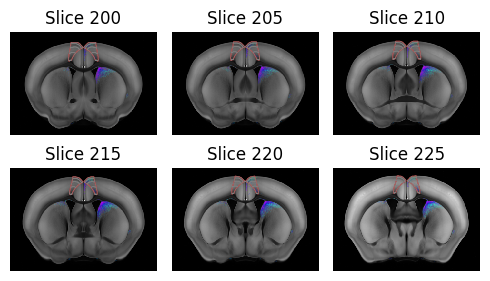

In [155]:
from matplotlib.colors import hsv_to_rgb, Normalize, LinearSegmentedColormap

# Show coronal slice 200
#From 20 to 150

# Settings
start_slice = 20
end_slice = 150
step = 5
axis = 1  # e.g., 0 = coronal, 1 = horizontal, 2 = sagittal

MOs_mask, _ = mcc.get_structure_mask(993)
MOs1_mask, _ = mcc.get_structure_mask(656)
MOs2_3_mask, _ = mcc.get_structure_mask(962)
MOs5_mask, _ = mcc.get_structure_mask(767)
MOs6a_mask, _ = mcc.get_structure_mask(1021)
MOs6b_mask, _ = mcc.get_structure_mask(1085)
combined_mask = (
    MOs1_mask |
    MOs2_3_mask |
    MOs5_mask |
    MOs6a_mask |
    MOs6b_mask
)

region_masks = {
    'MOs':     (MOs_mask, 'red'),
    'MOs1':    (MOs1_mask, 'grey'),
    'MOs2/3':  (MOs2_3_mask, 'grey'),
    'MOs5':    (MOs5_mask, 'grey'),
    'MOs6a':   (MOs6a_mask, 'grey'),
    'MOs6b':   (MOs6b_mask, 'grey')
}

fig, axes = plt.subplots(2, 3, figsize=(5,3))
axes = axes.flatten()

for i in range(6):
    slice_idx =200 + i * 5
    ax = axes[i]
    slice_hsv_overlay(
        selectivity_index,
        combined_prdens_sum,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks  # Pass the dict of region masks + colors
    )
    ax.set_title(f"Slice {slice_idx}")




plt.tight_layout()

You can also save these different slices in a gif, to have a fancy video to look at to better understand MOs projection from VIS and AUD areas and their contribution (it may take a while)

In [156]:
import imageio.v2 as imageio
import os

# Create directory to store frames
os.makedirs("frames", exist_ok=True)
filenames = []

# Generate frames with higher resolution (e.g., 6 inches × 4 inches at 200 DPI)
for i in range(263):
    slice_idx = 0 + i * 2
    fig, ax = plt.subplots(figsize=(10, 12), dpi=100)

    slice_hsv_overlay(
        selectivity_index,
        combined_prdens_sum,
        template,
        slice_index=slice_idx,
        axis=0,
        ax=ax,
        structure_masks=region_masks
    )
    
    ax.set_title(f"Slice {slice_idx}", fontsize=10)
    ax.axis("off")

    fname = f"frames/frame_{i:02d}.png"
    fig.savefig(fname, bbox_inches="tight")
    filenames.append(fname)
    plt.close(fig)

# Make the loop smooth by going forward and then backward
loop_filenames = filenames + filenames[::-1][1:-1]

# Create a looping GIF with 10 fps (0.1 sec per frame)
with imageio.get_writer("stack_slices_loop.gif", mode="I", duration=0.1, loop=0) as writer:
    for fname in loop_filenames:
        image = imageio.imread(fname)
        writer.append_data(image)

print("GIF saved as 'stack_slices_loop.gif' with higher resolution and smooth looping.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..1.2740012e+32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..6.35e-43].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..6.35e-43].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..6.35e-43].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..6.35e-43].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0..6.35e-43].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6715400.0

GIF saved as 'stack_slices_loop.gif' with higher resolution and smooth looping.


# 10. Correlation Analysis
I try to plot correlation matrices for MOs active pixels between different subregions in the VIs and AUD cortices

In [157]:
# Get all experiments metadata
all_experiments = mcc.get_experiments(dataframe=True)

# Get metadata for the vis and aud experiments
aud_meta = all_experiments[all_experiments['id'].isin(experiment_ids_aud)]
vis_meta = all_experiments[all_experiments['id'].isin(experiment_ids_vis)]

In [ ]:
# Group experiments by injection structure
aud_groups = aud_meta.groupby('structure_abbrev')
vis_groups = vis_meta.groupby('structure_abbrev')

In [159]:
# Create Sum Projection density maps per main injection structure
group_avg_maps = {}

#For auditory areas
for name, group in aud_groups:
    avg_map = None
    for exp_id in group['id']:
        prdens, _ = mcc.get_projection_density(exp_id)
        if avg_map is None:
            avg_map = np.zeros_like(prdens, dtype=np.float32)
        avg_map += prdens
    avg_map /= len(group)
    group_avg_maps[name] = avg_map

#For visual areas
for name, group in vis_groups:
    avg_map = None
    for exp_id in group['id']:
        prdens, _ = mcc.get_projection_density(exp_id)
        if avg_map is None:
            avg_map = np.zeros_like(prdens, dtype=np.float32)
        avg_map += prdens
    avg_map /= len(group)
    group_avg_maps[name] = avg_map

In [176]:
# Extract values in MOs
values_in_mos = {}
for name, pr_map in group_avg_maps.items():
    values = pr_map[MOs_mask.astype(bool)]
    values_in_mos[name] = values[np.isfinite(values)]  # remove NaNs

In [177]:

from scipy.stats import pearsonr
import seaborn as sns

# Create a DataFrame from values_in_mos (fill shorter lists with NaNs)
correlation_df = pd.DataFrame(dict([
    (key, pd.Series(values)) for key, values in values_in_mos.items()
]))


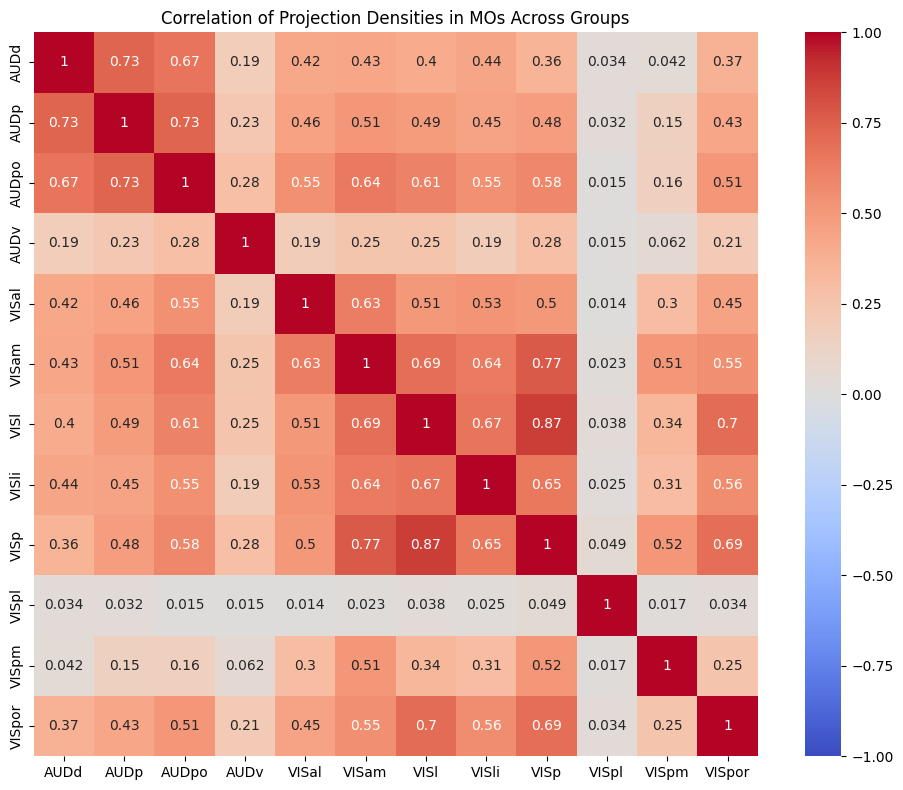

In [179]:
# Compute correlation matrix
corr_matrix = correlation_df.corr(method='pearson')

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation of Projection Densities in MOs Across Groups")
plt.tight_layout()
plt.show()

How correlated are the different injection areas across the whole brain (not specifically in MOS)

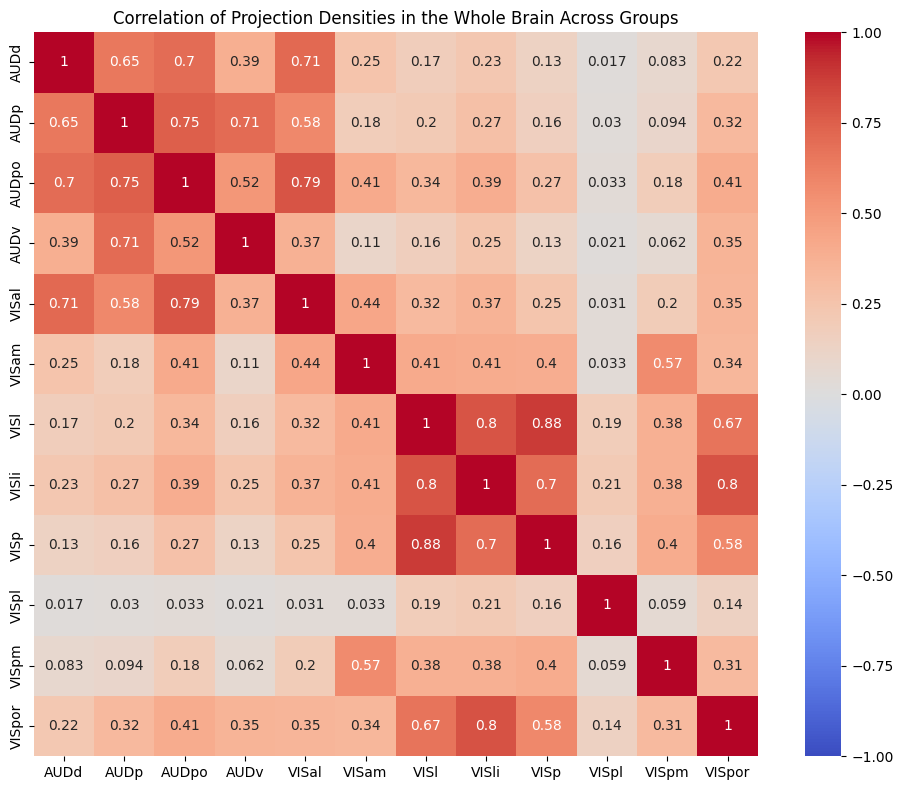

In [173]:
# Flatten each average map into 1D, build DataFrame
df = pd.DataFrame({k: pd.Series(v.ravel()) for k, v in group_avg_maps.items()})
df = df.dropna()  # remove NaNs

# Compute correlation matrix
corr_matrix = df.corr(method='pearson')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation of Projection Densities in the Whole Brain Across Groups")
plt.tight_layout()
plt.show()


How correlated are the different experiments between each other for main subareas

In [184]:
# Convert groups to dictionary: {subarea: [experiment_ids]}
aud_exp_dict = {name: list(group["id"]) for name, group in aud_groups}
vis_exp_dict = {name: list(group["id"]) for name, group in vis_groups}

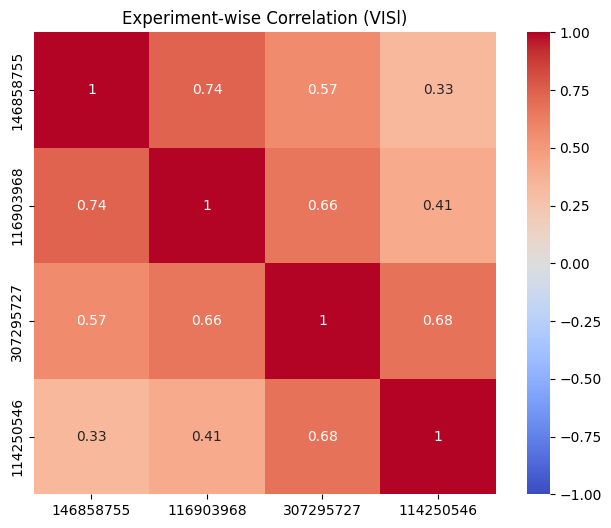

In [185]:
def correlation_matrix_for_group(exp_ids, mask=None):
    """
    Compute correlation matrix for all experiments in a group.
    
    exp_ids : list of experiment IDs
    mask    : binary 3D mask (optional) to restrict analysis (e.g., MOs only)
    """
    # Collect flattened projection maps
    flat_maps = {}
    for exp_id in exp_ids:
        pr_map, _ = mcc.get_projection_density(exp_id)

        if mask is not None:
            pr_map = np.where(mask, pr_map, np.nan)  # keep only masked region

        flat_maps[exp_id] = pr_map.ravel()  # flatten to 1D

    # Convert into DataFrame (rows=pixels, cols=experiments)
    df = pd.DataFrame(flat_maps)

    # Drop pixels that are NaN everywhere (outside tissue)
    df = df.dropna(how="all")

    # Compute correlation matrix between experiments
    corr = df.corr(method="pearson")

    return corr

# Example: compute correlation matrix for VISl group
corr_VISl = correlation_matrix_for_group(vis_exp_dict["VISl"], mask=None)
corr_AUDp = correlation_matrix_for_group(aud_exp_dict["AUDp"], mask=MOs_mask)


# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(corr_visl, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Experiment-wise Correlation (VISl)")
plt.show()


# 11. Projection signal strength 

Check for projection signal strength from the different subareas to MOs. You will also find the code in the script to normalize the projection strength value to the injection volume of the experiment.

In [164]:
# Initialize empty dictionary to store normalized projection values per group
VIS_group_results = {}
AUD_group_results = {}
VIS_group_counts = {}
AUD_group_counts = {}

In [ ]:
# Loop through VIS groups
for name, group in vis_groups:
    VIS_group_values = []
    
    for _, row in group.iterrows():
        exp_id = row['id']
        inj_vol = row['injection_volume']

        # Load projection density for this experiment
        pr_map, _ = mcc.get_projection_density(exp_id)

        # Sum projection density values inside MOs safely
        summed_proj = np.nansum(pr_map * (MOs_mask > 0))

        # Normalize by injection volume
        #norm_proj = summed_proj / inj_vol if inj_vol > 0 else np.nan
        VIS_group_values.append(summed_proj) # To do the normaliztion, change the argument to norm_proj

    # Store results for this group
    VIS_group_results[name] = VIS_group_values
    VIS_group_counts[name] = len(group)  # store number of experiments

In [ ]:
# Loop through AUD groups
for name, group in aud_groups:
    AUD_group_values = []
    
    for _, row in group.iterrows():
        exp_id = row['id']
        inj_vol = row['injection_volume']

        # Load projection density for this experiment
        pr_map, _ = mcc.get_projection_density(exp_id)

        # Sum projection density values inside MOs safely
        summed_proj = np.nansum(pr_map * (MOs_mask > 0))

        # Normalize by injection volume
        #norm_proj = summed_proj / inj_vol if inj_vol > 0 else np.nan
        AUD_group_values.append(summed_proj) # To do the normaliztion, change the argument to norm_proj

    # Store results for this group
    AUD_group_results[name] = AUD_group_values
    AUD_group_counts[name] = len(group)  # store number of experiments

Boxplots for VIS subareas

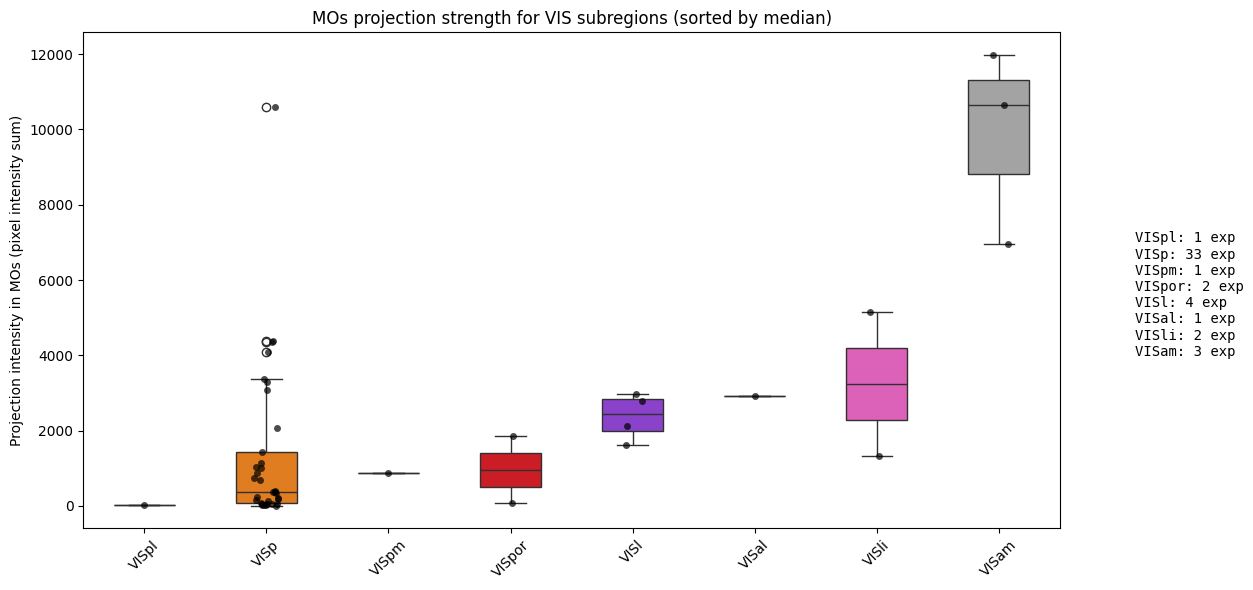

In [169]:

# Compute medians for each group
group_medians = {name: np.nanmedian(vals) for name, vals in VIS_group_results.items()}

# Sort area names by median value (ascending)
ordered_vis = sorted(group_medians, key=group_medians.get)

# Filter and order data
ordered_data = [VIS_group_results[name] for name in ordered_vis if name in VIS_group_results]

plt.figure(figsize=(12, 6))
sns.boxplot(data=ordered_data, orient="v", width=0.5, palette="bright")
sns.stripplot(data=ordered_data, orient="v", jitter=True, color="black", alpha=0.7)

plt.xticks(range(len(ordered_vis)), ordered_vis, rotation=45)
plt.ylabel("Projection intensity in MOs (pixel intensity sum)")
plt.title("MOs projection strength for VIS subregions (sorted by median)")

# Legend with counts (ordered)
legend_text = "\n".join([f"{name}: {VIS_group_counts.get(name, 0)} exp" for name in ordered_vis])
plt.gcf().text(0.95, 0.5, legend_text, va='center', ha='left', fontsize=10, family="monospace")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

Boxplots for AUD subareas

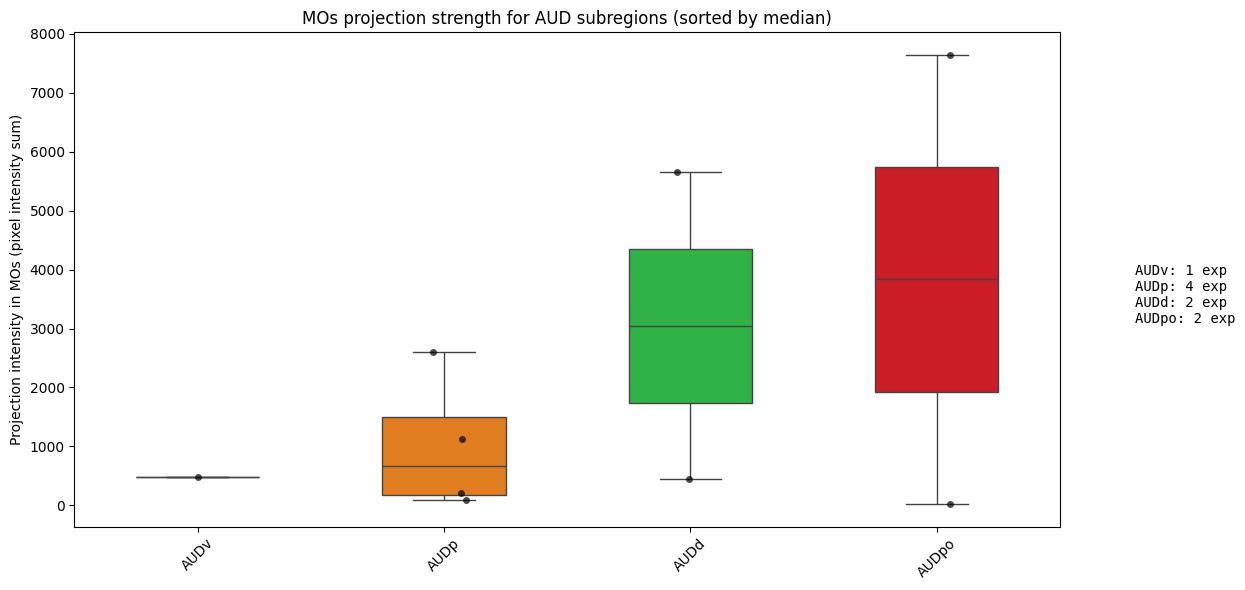

In [170]:
# Compute medians for each group
group_medians = {name: np.nanmedian(vals) for name, vals in AUD_group_results.items()}

# Sort area names by median value (ascending)
ordered_aud = sorted(group_medians, key=group_medians.get)

# Filter and order data
ordered_data = [AUD_group_results[name] for name in ordered_aud if name in AUD_group_results]

plt.figure(figsize=(12, 6))
sns.boxplot(data=ordered_data, orient="v", width=0.5, palette="bright")
sns.stripplot(data=ordered_data, orient="v", jitter=True, color="black", alpha=0.7)

plt.xticks(range(len(ordered_aud)), ordered_aud, rotation=45)
plt.ylabel("Projection intensity in MOs (pixel intensity sum)")
plt.title("MOs projection strength for AUD subregions (sorted by median)")

# Legend with counts (ordered)
legend_text = "\n".join([f"{name}: {AUD_group_counts.get(name, 0)} exp" for name in ordered_aud])
plt.gcf().text(0.95, 0.5, legend_text, va='center', ha='left', fontsize=10, family="monospace")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()